In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
crimes = pd.read_csv("../data/out/enriched_cta_crime_data.csv", index_col=0)
cta = pd.read_csv("../data/out/enriched_cta_data.csv", index_col=0)

/Users/danielturcza/anaconda/envs/PythonData/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [65]:
from datetime import datetime
import time

In [66]:
crimes["date_obj"] = crimes["date"].map(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))
crimes["date_only"] = crimes["date_obj"].map(lambda x: x.date())
crimes["month"] = crimes["date_only"].map(lambda x: x.month)

cta["date_obj"] = cta["date"].map(lambda x: datetime.strptime(x, "%m/%d/%Y"))
cta["month"] = cta["date_obj"].map(lambda x: x.month)

In [67]:
# filter out crimes we don't care about
crimes_other = crimes[crimes.primary_type.isin(["DECEPTIVE PRACTICE", "NARCOTICS"])]
crimes = crimes[~crimes.primary_type.isin(["DECEPTIVE PRACTICE", "NARCOTICS"])]

In [68]:
def cpm(column, selectors=None):
    if selectors:
        selectors = selectors + [column]
    else:
        selectors = [column]
    return 1000000 * crimes.fillna(0).groupby(selectors)["crimes_split"].sum() / cta.fillna(0).groupby(selectors)["rides_split"].sum()

In [69]:
cta.rename({"date_obj": "date_only"}, axis="columns", inplace=True)
cta.rename({"stationname": "station_name", "station_id": "map_id"}, axis="columns", inplace=True)

In [70]:
cta["year"] = cta["date_only"].map(lambda x: x.year)
crimes["year"] = crimes["date_only"].map(lambda x: x.year)

In [71]:
# show that 2018 numbers are down because they exclude Q4 (we adjust for this below)
cta.groupby(["year"])["rides_split"].sum()

year
2001    1.466204e+08
2002    1.473467e+08
2003    1.452662e+08
2004    1.428528e+08
2005    1.488319e+08
2006    1.563623e+08
2007    1.540562e+08
2008    1.613133e+08
2009    1.633997e+08
2010    1.696625e+08
2011    1.800477e+08
2012    1.856097e+08
2013    1.823806e+08
2014    1.904562e+08
2015    1.946706e+08
2016    1.925489e+08
2017    1.866775e+08
2018    1.391535e+08
Name: rides_split, dtype: float64

In [72]:
crimes_by_type = crimes.groupby(["year", "description"])["crimes_split"].sum().unstack().fillna(0)
cta_by_type = cta.groupby(["year"])["rides_split"].sum()

In [73]:
# adjust for the fact that we only have months 1-9 in 2018
cta_by_type.loc[2018] = cta_by_type.loc[2018] * 1.333

In [74]:
crimes_by_type["ridership"] = cta_by_type

In [75]:
crimes_of_interest = ['POCKET-PICKING', '$500 AND UNDER', 'SIMPLE', 'OVER $500', 'STRONGARM - NO WEAPON']

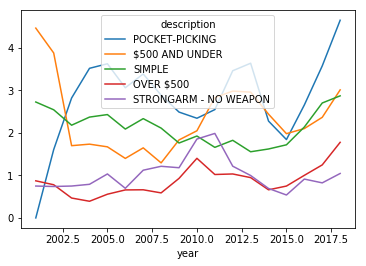

In [76]:
crimes_by_type.apply(lambda x: 1000000 * x / x['ridership'], axis=1).sort_values(by=2018, axis=1, ascending=False)[crimes_of_interest].plot(kind="line")

In [77]:
cta_adj = cta.groupby("year")["rides_split"].sum()
cta_adj.loc[2018] = cta_adj.loc[2018] * 1.333

### Crime on the CTA has roughly doubled in the last 3 years

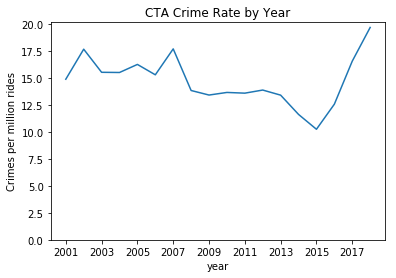

In [174]:
(1000000 * crimes.groupby("year")["crimes_split"].sum() / cta_adj).plot(kind="line")
plt.ylim(bottom=0)
plt.ylabel("Crimes per million rides")
plt.title("CTA Crime Rate by Year")
plt.xticks(range(2001, 2019, 2));

In [180]:
# numbers from chart above
(1000000 * crimes.groupby("year")["crimes_split"].sum() / cta_adj)

year
2001    14.888788
2002    17.672608
2003    15.530111
2004    15.512468
2005    16.259960
2006    15.297800
2007    17.701333
2008    13.842628
2009    13.421078
2010    13.662420
2011    13.596400
2012    13.883973
2013    13.411512
2014    11.624719
2015    10.248082
2016    12.573427
2017    16.563323
2018    19.688214
dtype: float64

# Thefts drive the majority of the increase

In [79]:
crime_rates = (1000000 * crimes.groupby(["year", "primary_type"])["crimes_split"].sum() / cta_adj)
three_year_diff = crime_rates.loc[[2015, 2018]].unstack().transpose().sort_values(by=2018, ascending=False)
three_year_diff["Delta"] = three_year_diff[2018] - three_year_diff[2015]
three_year_diff["% Change"] = three_year_diff[2018] / three_year_diff[2015]
three_year_diff

year                                   2015      2018     Delta  % Change
primary_type                                                             
THEFT                              4.885176  9.887236  5.002060  2.023926
BATTERY                            2.013658  3.364032  1.350374  1.670607
CRIMINAL DAMAGE                    0.770532  1.665843  0.895310  2.161937
ROBBERY                            0.888681  1.660452  0.771771  1.868446
CRIMINAL TRESPASS                  0.493141  1.277685  0.784545  2.590914
ASSAULT                            0.626700  0.889528  0.262828  1.419384
SEX OFFENSE                        0.138696  0.280336  0.141640  2.021229
PUBLIC PEACE VIOLATION             0.164380  0.215643  0.051263  1.311855
INTERFERENCE WITH PUBLIC OFFICER   0.041095  0.134777  0.093682  3.279638
OTHER OFFENSE                      0.092464  0.123995  0.031531  1.341008
WEAPONS VIOLATION                  0.041095  0.059302  0.018207  1.443041
CRIM SEXUAL ASSAULT                0.030821  0.037738  0.006916  1.224398
LIQUOR LAW VIOLATION               0.005137  0.021564  0.016427  4.197937
OFFENSE INVOLVING CHILDREN         0.025684  0.016173 -0.009511  0.629690
KIDNAPPING                              NaN  0.010782       NaN       NaN
PUBLIC INDECENCY                        NaN  0.010782       NaN       NaN
STALKING                           0.005137  0.005391  0.000254  1.049484
ARSON                              0.010274  0.005391 -0.004883  0.524742
OBSCENITY                               NaN  0.005391       NaN       NaN
HOMICIDE                                NaN  0.005391       NaN       NaN
GAMBLING                           0.005137  0.005391  0.000254  1.049484
MOTOR VEHICLE THEFT                0.005137  0.005391  0.000254  1.049484
CONCEALED CARRY LICENSE VIOLATION  0.005137       NaN       NaN       NaN

# Pickpocketing especially, though other thefts are also common

In [89]:
crime_rates_desc = (1000000 * crimes.groupby(["year", "description"])["crimes_split"].sum() / cta_adj)
three_year_diff = crime_rates_desc.loc[[2015, 2018]].unstack().transpose().sort_values(by=2018, ascending=False)
three_year_diff["Delta"] = three_year_diff[2018] - three_year_diff[2015]
three_year_diff["% Change"] = three_year_diff[2018] / three_year_diff[2015]
three_year_diff

year                                      2015      2018     Delta  % Change
description                                                                 
POCKET-PICKING                        1.844141  4.652500  2.808359  2.522855
$500 AND UNDER                        1.982837  3.013612  1.030775  1.519849
SIMPLE                                1.720856  2.873444  1.152588  1.669776
OVER $500                             0.749985  1.779056  1.029071  2.372122
STRONGARM - NO WEAPON                 0.539373  1.045869  0.506496  1.939047
TO STATE SUP LAND                     0.303076  0.878746  0.575670  2.899422
TO PROPERTY                           0.138696  0.609192  0.470496  4.392285
CRIMINAL DEFACEMENT                   0.431498  0.539108  0.107610  1.249386
TO LAND                               0.190065  0.393549  0.203484  2.070604
PRO EMP HANDS NO/MIN INJURY           0.246570  0.366593  0.120023  1.486769
TO CITY OF CHICAGO PROPERTY           0.128422  0.307291  0.178869  2.392824
PURSE-SNATCHING                       0.195202  0.285727  0.090526  1.463754
DOMESTIC BATTERY SIMPLE               0.256844  0.264163  0.007319  1.028494
ARMED: HANDGUN                        0.107875  0.221034  0.113160  2.048993
AGGRAVATED:KNIFE/CUTTING INSTR        0.118148  0.194079  0.075930  1.642671
RECKLESS CONDUCT                      0.143833  0.161732  0.017900  1.124447
PUBLIC INDECENCY                      0.077053  0.156341  0.079288  2.029003
AGGRAVATED: OTHER DANG WEAPON         0.082190  0.145559  0.063369  1.771004
AGG PO HANDS NO/MIN INJURY            0.066779  0.134777  0.067997  2.018239
TO STATE SUP PROP                     0.051369  0.134777  0.083408  2.623710
AGGRAVATED                            0.092464  0.118604  0.026140  1.282703
ATTEMPT: STRONGARM-NO WEAPON          0.056506  0.107822  0.051316  1.908153
CRIMINAL SEXUAL ABUSE                 0.030821  0.102430  0.071609  3.323366
ATTEMPT THEFT                         0.051369  0.091648  0.040279  1.784123
OBSTRUCTING IDENTIFICATION            0.015411  0.091648  0.076238  5.947077
ARMED:KNIFE/CUTTING INSTRUMENT        0.030821  0.086257  0.055436  2.798624
TO VEHICLE                            0.020548  0.080866  0.060319  3.935566
FROM BUILDING                         0.061643  0.064693  0.003050  1.049484
AGG: HANDS/FIST/FEET NO/MINOR INJURY  0.051369  0.059302  0.007933  1.154433
AGGRAVATED: HANDGUN                   0.015411  0.043129  0.027718  2.798624
...                                        ...       ...       ...       ...
AGGRAVATED OF A CHILD                      NaN  0.005391       NaN       NaN
AGGRAVATED: OTHER                     0.010274  0.005391 -0.004883  0.524742
ARSON THREAT                               NaN  0.005391       NaN       NaN
ATT CRIM SEXUAL ABUSE                 0.005137  0.005391  0.000254  1.049484
ATTEMPT NON-AGGRAVATED                     NaN  0.005391       NaN       NaN
OTHER ARSON/EXPLOSIVE INCIDENT             NaN  0.005391       NaN       NaN
CHILD ABANDONMENT                          NaN  0.005391       NaN       NaN
AUTOMOBILE                            0.005137  0.005391  0.000254  1.049484
OBSCENITY                                  NaN  0.005391       NaN       NaN
SEX OFFENDER: FAIL REG NEW ADD             NaN  0.005391       NaN       NaN
CHILD ABDUCTION                            NaN  0.005391       NaN       NaN
FALSE POLICE REPORT                   0.010274  0.005391 -0.004883  0.524742
FIRST DEGREE MURDER                        NaN  0.005391       NaN       NaN
GUN OFFENDER: DUTY TO REGISTER             NaN  0.005391       NaN       NaN
PAROLE VIOLATION                           NaN  0.005391       NaN       NaN
OTHER WEAPONS VIOLATION               0.005137  0.005391  0.000254  1.049484
INDECENT SOLICITATION/CHILD                NaN  0.005391       NaN       NaN
OTHER OFFENSE                         0.015411  0.005391 -0.010020  0.349828
GAME/DICE                             0.005137  0.005391  0.000254  1.049

### Graph demonstration of pickpocketing increase

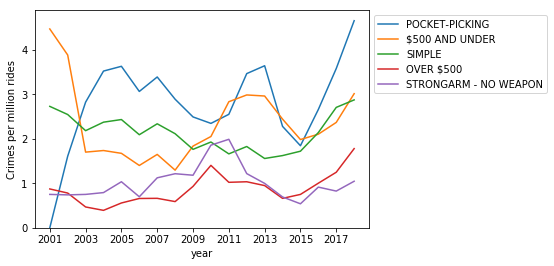

In [88]:
crimes_by_type.apply(lambda x: 1000000 * x / x['ridership'], axis=1).sort_values(by=2018, axis=1, ascending=False)[crimes_of_interest].plot(kind="line")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(bottom=0)
plt.ylabel("Crimes per million rides")
plt.xticks(range(2001, 2019, 2));

In [90]:
community_areas = pd.read_csv("../data/community_areas.csv", index_col=0)

In [91]:
crimes["area_name"] = crimes[["community_area"]].merge(community_areas, how="left", left_on="community_area", right_index=True)["area_name"]

Potential drivers of the increase

1. Is it the same number of crimes, but ridership is just down? __No - ridership has only dropped about 5%.__
1. Is it more of our ridership shifting to areas that have historically been more dangerous? E.g. maybe Loop ridership is up, and the Loop is always more dangerous than other areas, but is not more so than it was 3 years ago. __Nope. The Loop is almost 3x as dangerous as it was 3 years ago. Loop ridership is up only trivially since 2015.__
1. Decrease in fare evasion has made the system an easier target for criminals. __A possible theory. Hard to prove causality with the data we have. The timing is a _little_ off -- there's a couple year lag between the fare evasion decrease and the increase in thefts, but it could be a contributor. It's also actionable and very study-able, since it depends on CTA policy.__
1. System safety is no different than it was, but folks are reporting crimes more often than they were before (perhaps due to more or better reporting channels). __Possible contributor, but unlikely for two reasons. If this was the main driver, we might assume that crimes should be going up relatively evenly across the board, rather than seeing the spike in thefts and in the spike in certain areas. And more importantly, since this data comes from the CPD, we could expect to see citywide trends following the same pattern (e.g. everyone is more comfortable reporting things to the police, so crime has "gone up" in Chicago generally).__
1. Incentive to commit theft is up (the "more smartphones" theory). __I don't think this is a major driver. Smartphone penetration was already pretty strong in Chicago by 2015 - that is, there have been lots of smartphones on the train for a while. Smartphone snatching is quite the image, but let's be real - most passengers are watching their smartphones, not their wallets.__

What else?
1. Some change in CTA policy. They're best equipped to understand that.
1. A particular ring or group of thieves becoming popular/successful.
1. ??


The other angle we can look to dispel some of these theories is that some of them should be seen in other cities as well. For instance, if smartphones provide a better incentive and drive thieves to commit more thefts, we should see thefts up across the country. We don't yet know if that's the case.

# Overall ridership only dropped about 5% over the last 3 years, so that does not explain the crime rate increase

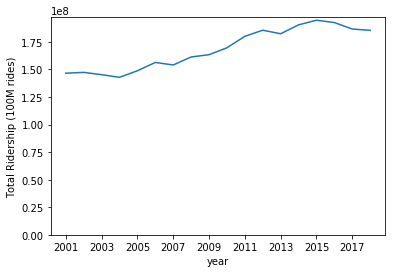

In [97]:
cta_adj.plot(kind="line")
plt.ylim(bottom=0)
plt.ylabel("Total Ridership (100M rides)")
plt.xticks(range(2001, 2019, 2));

In [99]:
# only a 5% decrease in ridership - not the main driver of crime increase
cta_adj[2018] / cta_adj[2015]

0.9528490851349898

In [181]:
cta_adj

year
2001    1.466204e+08
2002    1.473467e+08
2003    1.452662e+08
2004    1.428528e+08
2005    1.488319e+08
2006    1.563623e+08
2007    1.540562e+08
2008    1.613133e+08
2009    1.633997e+08
2010    1.696625e+08
2011    1.800477e+08
2012    1.856097e+08
2013    1.823806e+08
2014    1.904562e+08
2015    1.946706e+08
2016    1.925489e+08
2017    1.866775e+08
2018    1.854917e+08
Name: rides_split, dtype: float64

### There may be a relationship between Chicago's decrease in fare evasion from 2012-2015 and the increase in crime from 2015 on.

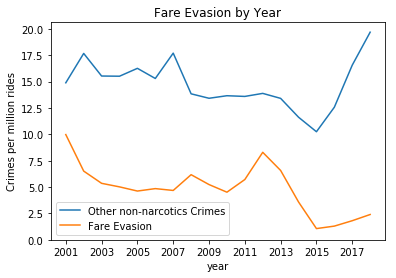

In [187]:
(1000000 * crimes.groupby("year")["crimes_split"].sum() / cta_adj).plot(kind="line")
(1000000 * crimes_other[crimes_other.primary_type == "DECEPTIVE PRACTICE"].groupby("year")["crimes_split"].sum() / cta_adj).plot(kind="line")
plt.ylim(bottom=0)
plt.ylabel("Crimes per million rides")
plt.title("Fare Evasion by Year")
plt.legend(["Non-narcotics Crimes", "Fare Evasion"])
plt.xticks(range(2001, 2019, 2));

# The view below is not the most accurate way to look at location and should probably just be deleted.

In [101]:
crimes_by_area_year = (1000000 * crimes.groupby(["year","area_name"])["crimes_split"].sum()).unstack().apply(lambda x: x / cta_adj[x.name], axis=1).fillna(0).sort_values(2018, axis=1, ascending=False)
crimes_by_area_year

area_name      LOOP  NEAR NORTH SIDE  ROGERS PARK  NEAR WEST SIDE  WEST TOWN  \
year                                                                           
2002       2.904714         1.004434     0.570084        0.454710   0.427563   
2003       3.600287         1.252872     0.647088        0.709043   0.309776   
2004       3.129094         1.232037     0.840025        0.553017   0.413012   
2005       3.419967         1.236294     0.752527        0.624866   0.456891   
2006       3.025025         0.946519     0.901752        0.524423   0.287793   
2007       3.940121         1.122967     0.837357        0.739990   0.454380   
2008       2.913585         0.843080     0.731496        0.681903   0.216969   
2009       2.588744         0.924114     0.691556        0.618116   0.195839   
2010       2.746630         1.096294     0.571723        0.601194   0.200398   
2011       2.815921         1.277440     0.483205        0.622058   0.227717   
2012       3.458871         1.185283     0.581866        0.554928   0.237057   
2013       3.580424         1.239167     0.701829        0.646999   0.394779   
2014       2.698783         0.960851     0.441046        0.477800   0.273029   
2015       2.116396         0.724301     0.636974        0.508551   0.215749   
2016       3.079736         0.836151     0.706314        0.482994   0.296029   
2017       4.381888         1.526697     1.001727        0.637463   0.589251   
2018       5.477335         1.536457     1.304641        0.862572   0.824835   

area_name  ROSELAND  LAKE VIEW    AUSTIN   CHATHAM  WEST GARFIELD PARK  \
year                                                                     
2002       0.481857   0.726179  0.285042  0.346123            0.128948   
2003       0.578249   0.970632  0.461222  0.468106            0.227169   
2004       0.812024   0.770023  0.378011  0.504015            0.273008   
2005       0.826436   0.772684  0.678618  0.611428            0.188132   
2006       0.850588   0.735471  0.569191  0.530818            0.172676   
2007       0.824375   0.642623  0.590694  0.454380            0.331048   
2008       0.706699   0.588916  0.688102  0.396743            0.316155   
2009       0.532437   0.673196  0.813955  0.348838            0.324358   
2010       0.471524   0.624770  0.919473  0.394902            0.500995   
2011       0.444327   0.599841  0.594287  0.422110            0.483205   
2012       0.414849   0.624967  0.527990  0.538765            0.274770   
2013       0.345431   0.597651  0.405745  0.274152            0.263186   
2014       0.477800   0.593312  0.446297  0.294031            0.288780   
2015       0.488004   0.452046  0.405814  0.380129            0.241434   
2016       0.560896   0.571283  0.389511  0.529735            0.311609   
2017       0.712459   0.589251  0.364265  0.567824            0.353551   
2018       0.776315   0.754751  0.673885  0.619974            0.522934   

area_name    ...     CHICAGO LAWN   OAKLAND  CLEARING  NORTH PARK   DUNNING  \
year         ...                                                              
2002         ...         0.006787  0.000000  0.000000    0.006787  0.000000   
2003         ...         0.006884  0.000000  0.013768    0.000000  0.000000   
2004         ...         0.014000  0.000000  0.007000    0.000000  0.000000   
2005         ...         0.000000  0.000000  0.006719    0.006719  0.000000   
2006         ...         0.019186  0.000000  0.000000    0.000000  0.012791   
2007         ...         0.012982  0.000000  0.025965    0.006491  0.006491   
2008         ...         0.012398  0.000000  0.000000    0.000000  0.000000   
2009         ...         0.000000  0.000000  0.012240    0.018360  0.000000   
2010         ...         0.000000  0.000000  0.005894    0.000000  0.000000   
2011         ...         0.000000  0.005554  0.000000    0.000000  0.000000   
2012         ...         0.005388  0.000000  0.000000    0.005388  0.000000   
2013         ...         0.005483  0.000000  

### The Loop is seeing the largest increase in crime from 2015.

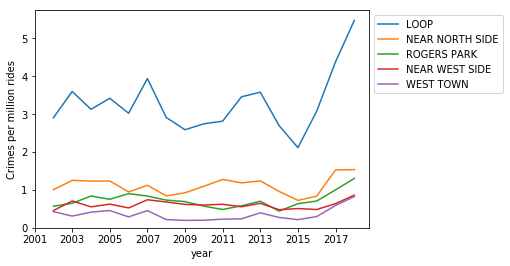

In [103]:
areas_of_interest = crimes_by_area_year[crimes_by_area_year.columns[:5]].plot(kind="line")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(bottom=0)
plt.ylabel("Crimes per million rides")
plt.xticks(range(2001, 2019, 2));

Despite the apparent difference in the chart, crime growth from 2015 as a percentage is much more similar across areas. However, since the Loop already represents a large area with a plurality of crimes, it still drives most of the overall increase.

In [120]:
pd.set_option('display.max_rows', 500)
community_areas

area_name
area_id                        
35                      DOUGLAS
36                      OAKLAND
37                  FULLER PARK
38              GRAND BOULEVARD
39                      KENWOOD
4                LINCOLN SQUARE
40              WASHINGTON PARK
41                    HYDE PARK
42                     WOODLAWN
1                   ROGERS PARK
11               JEFFERSON PARK
12                  FOREST GLEN
13                   NORTH PARK
14                  ALBANY PARK
15                 PORTAGE PARK
16                  IRVING PARK
17                      DUNNING
18                    MONTCLARE
19               BELMONT CRAGIN
2                    WEST RIDGE
20                      HERMOSA
21                     AVONDALE
22                 LOGAN SQUARE
23                HUMBOLDT PARK
24                    WEST TOWN
25                       AUSTIN
26           WEST GARFIELD PARK
27           EAST GARFIELD PARK
28               NEAR WEST SIDE
29               NORTH LAWNDALE
3                        UPTOWN
30               SOUTH LAWNDALE
31              LOWER WEST SIDE
33              NEAR SOUTH SIDE
34                ARMOUR SQUARE
10                 NORWOOD PARK
8               NEAR NORTH SIDE
32                         LOOP
43                  SOUTH SHORE
44                      CHATHAM
45                  AVALON PARK
46                SOUTH CHICAGO
47                     BURNSIDE
59                MCKINLEY PARK
6                     LAKE VIEW
48              CALUMET HEIGHTS
49                     ROSELAND
5                  NORTH CENTER
50                      PULLMAN
51                SOUTH DEERING
52                    EAST SIDE
53                 WEST PULLMAN
54                    RIVERDALE
55                    HEGEWISCH
56               GARFIELD RIDGE
57               ARCHER HEIGHTS
58                BRIGHTON PARK
60                   BRIDGEPORT
61                     NEW CITY
62                  WEST ELSDON
63                    GAGE PARK
64                     CLEARING
65                    WEST LAWN
66                 CHICAGO LAWN
67               WEST ENGLEWOOD
68                    ENGLEWOOD
69       GREATER GRAND CROSSING
7                  LINCOLN PARK
70                      ASHBURN
71               AUBURN GRESHAM
72                      BEVERLY
73           WASHINGTON HEIGHTS
74              MOUNT GREENWOOD
75                  MORGAN PARK
76                        OHARE
77                    EDGEWATER
9                   EDISON PARK

In [136]:
most_common_community_area = crimes.groupby('map_id').apply(lambda x: x['community_area'].value_counts().idxmax())

In [141]:
cta_new = cta.merge(pd.DataFrame(most_common_community_area), left_on="map_id", right_index=True)

In [156]:
community_areas_map = community_areas.to_dict()

In [158]:
community_areas_map = community_areas_map['area_name']

In [159]:
pd.reset_option("display.max_rows")
cta_new = cta_new.rename({0: "community_area"}, axis=1)
cta_new["area_name"] = cta_new["community_area"].map(lambda x: community_areas_map[x])
cta_new

rides_split        date  map_id station_name variable  date_only  \
12971         1059.0  01/01/2001   40760    Granville      red 2001-01-01   
12972         2717.0  01/02/2001   40760    Granville      red 2001-01-02   
12973         2878.0  01/03/2001   40760    Granville      red 2001-01-03   
12974         2875.0  01/04/2001   40760    Granville      red 2001-01-04   
12975         3028.0  01/05/2001   40760    Granville      red 2001-01-05   
12976         1932.0  01/06/2001   40760    Granville      red 2001-01-06   
12977         1529.0  01/07/2001   40760    Granville      red 2001-01-07   
12978         3057.0  01/08/2001   40760    Granville      red 2001-01-08   
12979         3047.0  01/09/2001   40760    Granville      red 2001-01-09   
12980         2965.0  01/10/2001   40760    Granville      red 2001-01-10   
12981         3166.0  01/11/2001   40760    Granville      red 2001-01-11   
12982         3204.0  01/12/2001   40760    Granville      red 2001-01-12   
12983         2024.0  01/13/2001   40760    Granville      red 2001-01-13   
12984         1588.0  01/14/2001   40760    Granville      red 2001-01-14   
12985         2447.0  01/15/2001   40760    Granville      red 2001-01-15   
12986         3192.0  01/16/2001   40760    Granville      red 2001-01-16   
12987         3235.0  01/17/2001   40760    Granville      red 2001-01-17   
12988         3323.0  01/18/2001   40760    Granville      red 2001-01-18   
12989         3351.0  01/19/2001   40760    Granville      red 2001-01-19   
12990         2367.0  01/20/2001   40760    Granville      red 2001-01-20   
12991         1564.0  01/21/2001   40760    Granville      red 2001-01-21   
12992         3242.0  01/22/2001   40760    Granville      red 2001-01-22   
12993         3281.0  01/23/2001   40760    Granville      red 2001-01-23   
12994         3198.0  01/24/2001   40760    Granville      red 2001-01-24   
12995         3254.0  01/25/2001   40760    Granville      red 2001-01-25   
12996         3327.0  01/26/2001   40760    Granville      red 2001-01-26   
12997         2181.0  01/27/2001   40760    Granville      red 2001-01-27   
12998         1529.0  01/28/2001   40760    Granville      red 2001-01-28   
12999         3172.0  01/29/2001   40760    Granville      red 2001-01-29   
13000         3187.0  01/30/2001   40760    Granville      red 2001-01-30   
...              ...         ...     ...          ...      ...        ...   
7080134       1544.0  09/01/2018   40120  35th/Archer   orange 2018-09-01   
7080135       1154.0  09/02/2018   40120  35th/Archer   orange 2018-09-02   
7080136       1050.0  09/03/2018   40120  35th/Archer   orange 2018-09-03   
7080137       3285.0  09/04/2018   40120  35th/Archer   orange 2018-09-04   
7080138       3438.0  09/05/2018   40120  35th/Archer   orange 2018-09-05   
7080139       3408.0  09/06/2018   40120  35th/Archer   orange 2018-09-06   
7080140       3224.0  09/07/2018   40120  35th/Archer   orange 2018-09-07   
7080141       1603.0  09/08/2018   40120  35th/Archer   orange 2018-09-08   
7080142       1129.0  09/09/2018   40120  35th/Archer   orange 2018-09-09   
7080143       3482.0  09/10/2018   40120  35th/Archer   orange 2018-09-10   
7080144       3547.0  09/11/2018   40120  35th/Archer   orange 2018-09-11   
7080145       3567.0  09/12/2018   40120  35th/Archer   orange 2018-09-12   
7080146       3669.0  09/13/2018   40120  35th/Archer   orange 2018-09-13   
7080147       3267.0  09/14/2018   40120  35th/Archer   orange 2018-09-14   
7080148       1733.0  09/15/2018   40120  35th/Archer   orange 2018-09-15   
7080149       1232.0  09/16/2018   40120  35th/Archer   orange 2018-09-16   
7080150       3427.0  09/17/2018   40120  35th/Archer   orange 2018-09-17   
7080151       3595.0  09/18/2018   40120  35th/Archer   orange 2018-09-18   
7080152       3507.0  09/19/2018   40120  35th/Archer   orange 2018-09-19   
7080153       3518.0  09/20/2018   40120  35th/Archer   orange 2018-09-20   
70801

# This is a better approach to looking at crime rates by location, which shows that crime is definitely up in areas like the Loop after adjusting for ridership. Note that 2018 numbers aren't adjusted for the fact that we are missing Q4 data.

In [165]:
pd.set_option('display.max_columns', 100)
((1000000 * crimes.groupby(["year","area_name"])["crimes_split"].sum()) / (cta_new.groupby(["year","area_name"])["rides_split"].sum())).unstack().fillna(0).sort_values(2018, axis=1, ascending=False)

area_name  WEST GARFIELD PARK  WEST ENGLEWOOD  EAST GARFIELD PARK   ROSELAND  \
year                                                                           
2001                 0.000000        0.000000            0.000000   0.000000   
2002                22.707634       20.521239           16.704594  16.607962   
2003                39.288661       65.761167           30.156163  20.147663   
2004                49.895539       40.542159           29.227317  27.933580   
2005                33.124413       38.598187           29.816537  28.974733   
2006                29.747215       49.370022           31.704922  30.756892   
2007                54.460938       48.129372           45.731133  29.661698   
2008                50.842642       37.677059           32.919039  26.074582   
2009                50.145564       39.293787           46.109658  21.381469   
2010                69.854095       23.329700           51.990989  19.881309   
2011                67.662103       38.315181           66.158106  19.650685   
2012                38.918018       34.109149           29.849920  19.334132   
2013                38.778165       29.783058           30.681864  31.549501   
2014                43.859824       50.069158           29.850854  24.798350   
2015                39.142659       51.943242           21.468913  25.841797   
2016                54.370283       74.330495           31.132281  31.135333   
2017                64.667969      130.850446           41.254619  40.783209   
2018               132.288662      122.312938           71.177296  63.176293   

area_name  NORTH LAWNDALE  ENGLEWOOD  ROGERS PARK  FULLER PARK  \
year                                                             
2001             0.000000   0.000000     0.000000     0.000000   
2002            38.397420  16.900047    15.805535    16.552772   
2003            87.826299  28.584087    18.168738    25.938467   
2004            44.383787  46.112581    23.758528    29.086797   
2005            47.141380  31.743274    21.712054    28.460799   
2006            42.052366  32.523227    26.864240    38.108800   
2007            79.229975  35.649434    25.392556    26.909024   
2008            34.184895  25.693696    22.206176    32.035128   
2009            34.305546  38.742421    20.817689    29.771284   
2010            34.484511  26.897349    17.360204    28.453878   
2011            54.267825  31.737009    14.743569    29.321177   
2012            32.769669  41.579104    18.651416    37.395808   
2013            44.733999  28.556634    21.574268    31.838282   
2014            36.584929  38.637305    13.773689    20.854262   
2015            11.504964  31.952791    19.845169    20.043892   
2016            37.770531  38.132129    23.229736    28.682021   
2017            66.401393  45.796516    33.408553    33.964320   
2018            62.298521  61.554757    59.796938    57.343599   

area_name  NEAR SOUTH SIDE  GREATER GRAND CROSSING     AUSTIN    DOUGLAS  \
year                                                                       
2001              0.000000                0.000000   0.000000   0.000000   
2002              0.000000               33.004918  12.940533  11.829400   
2003              0.000000               41.773830  20.837558  26.575204   
2004              0.000000               49.018557  17.201670  35.352303   
2005              0.000000               41.262852  31.032151  41.960194   
2006              0.000000               33.097911  25.769375  27.739911   
2007              0.000000               43.470746  25.917759  43.080005   
2008              0.000000               42.458874  29.883640  28.850246   
2009              0.000000               42.468940  36.707123  31.482082   
2010              0.000000               46.231259  42.482920  17.433420   
2011              0.000000               33.939489  28.337367  44.096873   
2012              0.000000               46.787058  25.513213  32.337025   
2013          

In [172]:
loop = (cta_new.groupby(["year","area_name"])["rides_split"].sum()).unstack()['LOOP']
loop[2018] = loop[2018] * 1.333
loop

year
2001    3.371849e+07
2002    3.403443e+07
2003    3.231527e+07
2004    3.099004e+07
2005    3.141910e+07
2006    3.437608e+07
2007    3.596004e+07
2008    3.800893e+07
2009    3.835970e+07
2010    3.950026e+07
2011    4.176250e+07
2012    4.288892e+07
2013    4.319046e+07
2014    4.442833e+07
2015    4.682554e+07
2016    4.694768e+07
2017    4.671595e+07
2018    4.813294e+07
Name: LOOP, dtype: float64

In [173]:
(1000000 * crimes.groupby(["year","area_name"])["crimes_split"].sum()).unstack()['LOOP'] / loop

year
2001          NaN
2002    12.575501
2003    16.184302
2004    14.423989
2005    16.200339
2006    13.759566
2007    16.879849
2008    12.365515
2009    11.027199
2010    11.797391
2011    12.140079
2012    14.968900
2013    15.119081
2014    11.569195
2015     8.798617
2016    12.631083
2017    17.510080
2018    21.108204
Name: LOOP, dtype: float64